### Example Calibration with Known Functional Form - Friedman function
In this example, we calibrate the Friedman function, where one of the inputs is treated as a functional variable and there is no discrepancy.  This is a difficult calibration problem because, for any response, there are many combinations of inputs that produce equally good simulations.

#%pip install ../.

In [3]:
import numpy as np
from impala import superCal as sc
import impala.superCal.post_process as pp
import matplotlib.pyplot as plt

This is the Friedman function, where one of the inputs is functional in tt as follows. For this calibration, we will assume that the functional form f(x) is known. 

In [1]:
def f(x):
    out = 10. * np.sin(np.pi * tt * x[0]) + 20. * (x[1] - .5) ** 2 + 10 * x[2] + 5. * x[3]
    return out

Here, we generate some realizations from f, including 200 "prior simulations" and one simulation with noise that we will treat as our observations.  Note that we use 9 variables while f only uses 4, so we have 5 inert variables.

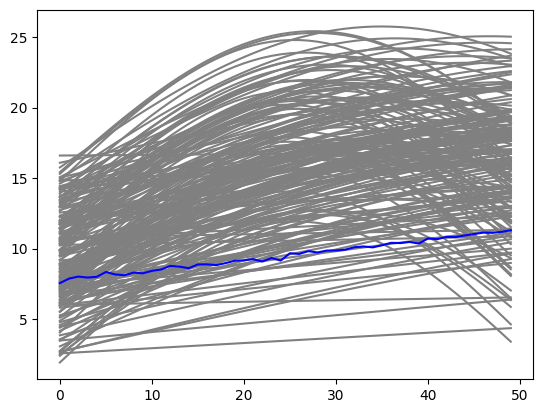

In [4]:
p = 9
nt = 50
tt = np.linspace(0, 1, nt)

xx_true = np.random.rand(1, p)
yobs = np.apply_along_axis(f, 1, xx_true).reshape(nt) + np.random.normal(size=50)*.1

x_prior = np.random.rand(200, p)
y_sim_prior = np.apply_along_axis(f, 1, x_prior)
plt.plot(y_sim_prior.T, color='grey', label='prior')
plt.plot(yobs, color='blue', label='obs')

Now we are ready to set up and run our calibration. Since the functional form of f(x) is assumed known and fast to compute, we specify the model to calibrate using the **ModelF** class.

In [5]:
input_names = [str(v) for v in list(range(p))] # list of input names
bounds = dict(zip(input_names, np.concatenate((np.zeros((p, 1)), np.ones((p, 1))), 1))) # bounds for each input

setup = sc.CalibSetup(bounds, constraint_func='bounds') # initialize with the only constraints being the bounds
model = sc.ModelF(f, input_names) # put f into the right structure; this could be replaced with an emulator
setup.addVecExperiments(yobs=yobs,     # observation vector
                        model=model,   # model that predicts a vector
                        sd_est=[1.],   # yobs error estimate (possibly a vector of estimates for different parts of yobs vector)
                        s2_df=[0],     # yobs error degrees of freedom (larger means more confidence in sd_est), same shape as sd_est
                        s2_ind=[0]*nt) # if sd_est is a vector of length 3, this is a vector of length len(yobs) with
                                         # values (0, 1, 2) indicating which sd_est corresponds to which part of yobs

# Note: if you have multiple experiments, just call setup.addVecExperiments multiple times
setup.setTemperatureLadder(1.05**np.arange(40)) # temperature ladder, typically (1 + step)**np.arange(ntemps) 
setup.setMCMC(nmcmc=15000,decor=100) # MCMC number of iterations, and how often to take a decorrelation step
out = sc.calibPool(setup) # pooled calibration (takes less than a minute)

[2024-04-24 12:33:27 | 14999/14999 (100%) | WALL: 0:00:39 | ETA: 0:00:00 | 381.55it/s]
Calibration MCMC Complete. Time: 39.320909 seconds.


We can look at trace plots of the calibration parameters (theta).  We want these to look like they converge, and choose which MCMC iterations to use accordingly. Convergence can sometimes be difficult to assess by eye, but we want these plots to look somewhat like fuzzy caterpillars that are lying totally flat. We will exclude any iterations at the start of the chain that don't exhibit this property. 

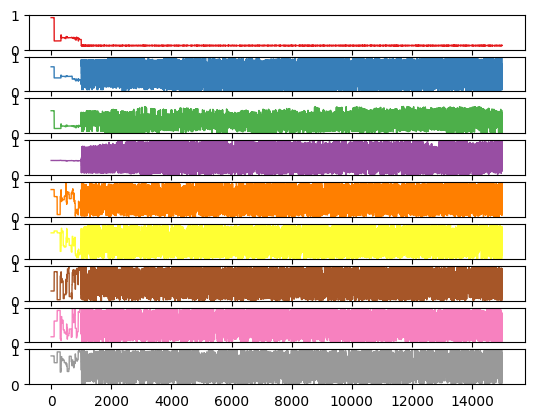

In [6]:
pp.parameter_trace_plot(out.theta[:, 0], ylim=[0, 1])

We disregard the first 5000 iterations and use every other iteration after that, which leaves us with 5000 iterations from our original 15000.  Here is the pairs plot of the calibration parameters' posterior (theta). 

Note how the posterior distributions for parameters 3-7 appear uniform across (0,1). These parameters are not identified, and this is to be expected. The strange posterior surface of the Friedman function is evident in the scatterplot for draws of parameters 1 and 2, which exhibits an arch-like features. Because IMPALA uses a sophisticated MCMC sampling scheme for parameter estimation, it is able to navigate this complicated posterior surface and produce sensible results. 

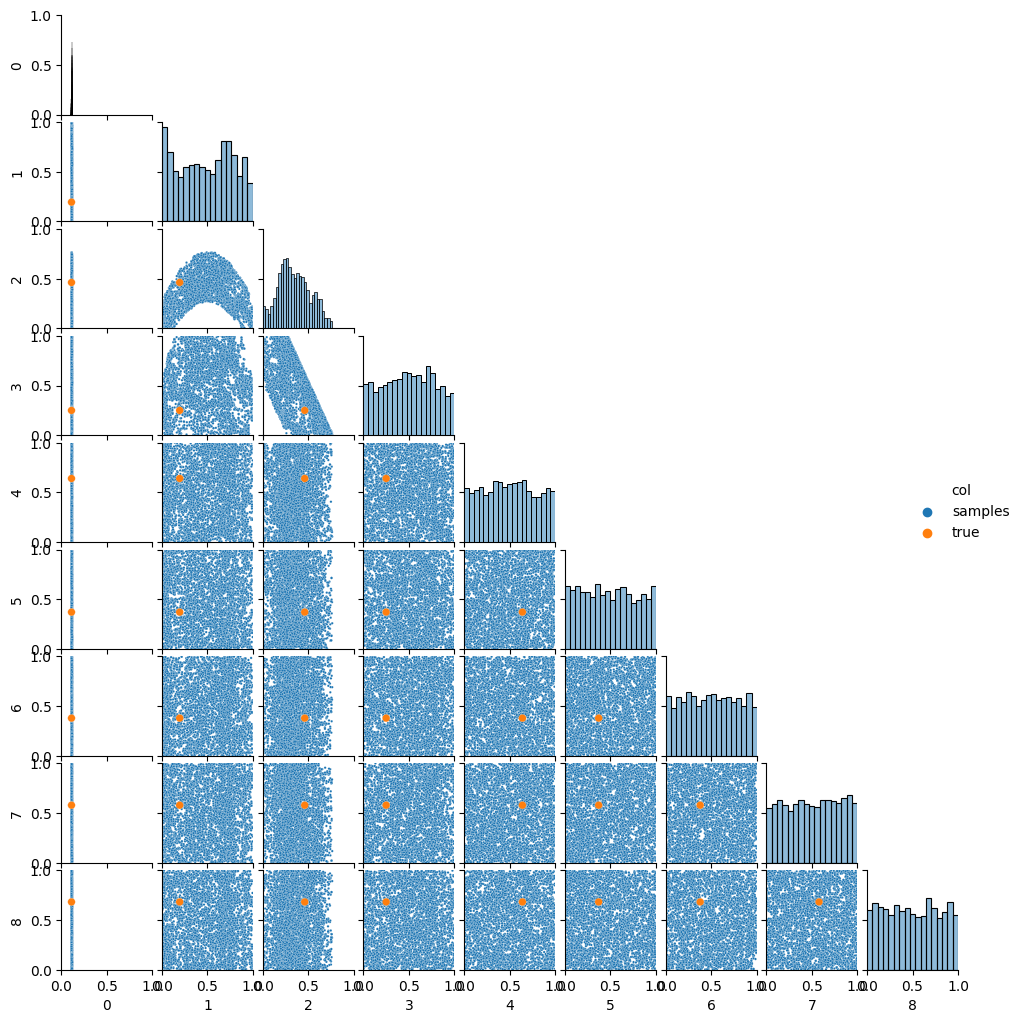

In [7]:
mcmc_use = np.arange(5000, 15000, 2) # burn and thin index
mat_theta_xxtrue = np.vstack((out.theta[mcmc_use, 0], sc.normalize(xx_true, setup.bounds_mat)))
col = ['samples']*len(mcmc_use) + ['true'] # color
s = [3]*len(mcmc_use) + [30] # size
pp.pairs(setup, mat_theta_xxtrue, col, s)

We also give the trace plot of the error variance (with the true values).

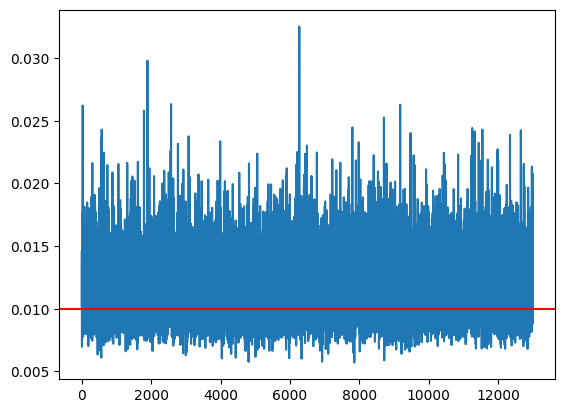

In [8]:
plt.plot(out.s2[0][2000:,0])
plt.axhline(0.01, color='r')

Let's produce our calibrated posterior predictions (with and without the observation error) with the observational data.

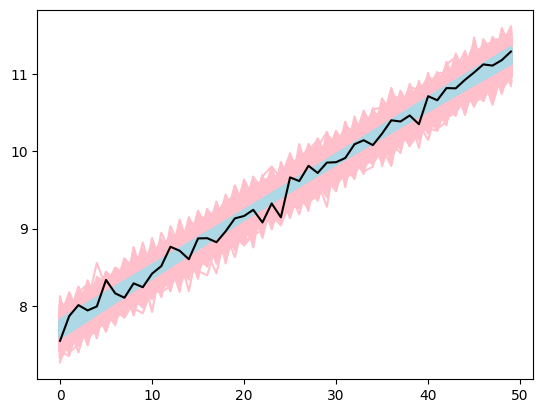

In [9]:
mat = np.array(list(out.theta_native.values())).T[mcmc_use]
pred = np.apply_along_axis(f, 1, mat).reshape(len(mcmc_use), nt)
pred_s2 = np.random.normal(size=(len(mcmc_use), nt)) * np.sqrt(out.s2[0][mcmc_use, 0])
plt.plot((pred + pred_s2).T, color='pink') # posterior predictions including noise
plt.plot(pred.T, color='lightblue') # posterior predictions of noiseless function
plt.plot(yobs, color='black') # observations

Now, suppose we want to obtain a single set of parameter estimates that best agree with out observed data. Several reasonable approaches exist, but here we identify the posterior draw of theta with the smallest squared prediction error.

In [10]:
pred_sse = np.sum((pred-np.repeat(setup.ys[0].reshape(1,-1), len(mcmc_use), axis = 0))**2,axis=1)
theta_minsse = mat[np.where(pred_sse == pred_sse.min())[0][0],:]

Now, let's add the "best" predictions to the former plot. 

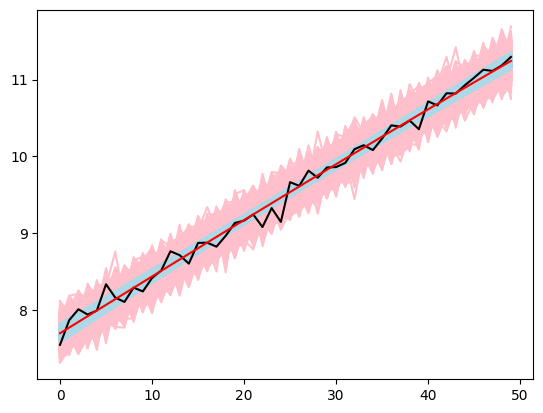

In [11]:
mat = np.array(list(out.theta_native.values())).T[mcmc_use]
pred = np.apply_along_axis(f, 1, mat).reshape(len(mcmc_use), nt)
pred_s2 = np.random.normal(size=(len(mcmc_use), nt)) * np.sqrt(out.s2[0][mcmc_use, 0])
plt.plot((pred + pred_s2).T, color='pink') # posterior predictions including noise
plt.plot(pred.T, color='lightblue') # posterior predictions of noiseless function
plt.plot(yobs, color='black') # observations
plt.plot(pred[np.where(pred_sse == pred_sse.min())[0][0],:], color='red') # observations
plt.show()